<h1 align="center">Tutorial: Bird by Bird using Deep Learning</h1>
<h2 align="center">Advancing deep learning models for fine-grained classification of bird species</h2>
<h3 align="center">Author: Sofya Lipnitskaya</h3>
<img src="images/background.jpg">

**Overview**

With this tutorial, you will tackle such an established problem in computer vision as fine-grained classification of bird species. The notebook demonstrates how to classify bird images from the Caltech-UCSD Birds-200-2011 ([CUB-200-2011](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html)) dataset using PyTorch, one of the most popular open-source frameworks for deep learning experiments. 

**Project outline** 

Here you can get familiarized with the content more properly (the respective CRISP-DM stages of the project are indicated in parentheses):

* Introducing the bird species recognition problem [(Business Understanding)](#motiv)
* Exploratory analysis of CUB-200-2011 dataset [(Data Understanding)](#data)
* Transforming images and splitting the data [(Data Preparation)](#prep) 
* Training and evaluation of the baseline model [(Modelling. p. 1/2)](#model-base)
* Advancing the deep learning model [(Modelling. p. 2/2)](#model-adv) 
* Conclusions and Future work [(Evaluation)](#eval)

**Learning Goals**

By the end of the tutorial, you will be able to:
- Understand basics of image classification problem of bird species.
- Determine the data-driven image pre-processing strategy.
- Create your own deep learning pipeline for image classification.
- Build, train and evaluate ResNet-50 model to predict bird species.
- Improve the model performance by using different techniques.

***

## Introducing the bird species recognition problem<a class="anchor" id="motiv"></a>

**Motivation** 

Bird species recognition is a difficult task challenging the visual abilities for both human experts and computers. One of the interesting task related to that problem implies the classification of birds by species using imagery data collected from aerial surveys. Bird populations are important biodiversity indicators, so collecting reliable data is quite [important](https://dl.acm.org/doi/10.1016/j.patrec.2015.08.015) to ecologists. Recognition of bird species also benefits companies developing wind farms producing renewable energy, since their construction requires the prior risk assessment of bird collisions, threatening many of the world’s species with extinction.

This, of course, would be a very ambitious plan to try to find the solution for this problem within a single notebook, so let's make it simple and focus on the bird classification. To make it even more concise, here, we are going to create and evaluate a deep learning model to classify bird images from the Caltech-UCSD Birds-200-2011 ([CUB-200-2011](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html)) dataset. In this tutorial, you will learn how to perform the data-driven image pre-processing, build a baseline ResNet-based classifier, and to improve its performance for even better results in bird species recognition using different techniques, which will be described later on.

**Questions to be solved through the notebook:**

1. Do corrupted images exist in our dataset?
2. What would be the optimal data transformation strategy?
3. Are there any image-specific biases that can limit the model performance?
4. How to handle overfitting given the limited amount of training samples?
5. How to improve the model performance in bird species recognition?

***

First, let's import packages that we will use in this tutorial:

In [2]:
# import packages
import os
import csv
import random
import tarfile
import multiprocessing as mp

import tqdm
import requests

import numpy as np
import sklearn.model_selection as skms

import torch
import torch.utils.data as td
import torch.nn.functional as F

import torchvision as tv
import torchvision.transforms.functional as TF

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# define constants
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
OUT_DIR = 'results'
RANDOM_SEED = 42

# create an output folder
os.makedirs(OUT_DIR, exist_ok=True)


def get_model_desc(pretrained=False, num_classes=200, use_attention=False):
    """
    Generates description string.  
    """
    desc = list()

    if pretrained:
        desc.append('Transfer')
    else:
        desc.append('Baseline')

    if num_classes == 204:
        desc.append('Multitask')

    if use_attention:
        desc.append('Attention')

    return '-'.join(desc)


def log_accuracy(path_to_csv, desc, acc, sep='\t', newline='\n'):
    """
    Logs accuracy into a CSV-file.
    """
    file_exists = os.path.exists(path_to_csv)

    mode = 'a'
    if not file_exists:
        mode += '+'

    with open(path_to_csv, mode) as csv:
        if not file_exists:
            csv.write(f'setup{sep}accuracy{newline}')

        csv.write(f'{desc}{sep}{acc}{newline}')

## Data collection<a class="anchor" id="data"></a>

In this tutorial, we are going to use CUB-200-2011 dataset consisting of 11788 images of birds belonging to 200 species. 

The dataset file can be downloaded and extracted manually from [link](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html 'www.vision.caltech.edu'), or, alternatively, using the following code:

In [3]:
class GoogleDriveDownloader(object):
    """
    Downloading a file stored on Google Drive by its URL.
    If the link is pointing to another resource, the redirect chain is being expanded.
    Returns the output path.
    """
    
    base_url = 'https://docs.google.com/uc?export=download'
    chunk_size = 32768
    
    def __init__(self, url, out_dir):
        super().__init__()
        
        self.out_name = url.rsplit('/', 1)[-1]
        self.url = self._get_redirect_url(url)
        self.out_dir = out_dir
    
    @staticmethod
    def _get_redirect_url(url):
        response = requests.get(url)
        if response.url != url and response.url is not None:
            redirect_url = response.url
            return redirect_url
        else:
            return url
    
    @staticmethod
    def _get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None
    
    def _save_response_content(self, response):
        with open(self.fpath, 'wb') as f:
            bar = tqdm.tqdm(total=None)
            progress = 0
            for chunk in response.iter_content(self.chunk_size):
                if chunk:
                    f.write(chunk)
                    progress += len(chunk)
                    bar.update(progress - bar.n)
            bar.close()
    
    @property
    def file_id(self):
        return self.url.split('?')[0].split('/')[-2]
    
    @property
    def fpath(self):
        return os.path.join(self.out_dir, self.out_name)
    
    def download(self):
        os.makedirs(self.out_dir, exist_ok=True)
        
        if os.path.isfile(self.fpath):
            print('File is downloaded yet:', self.fpath)
        else:
            session = requests.Session()
            response = session.get(self.base_url, params={'id': self.file_id}, stream=True)
            token = self._get_confirm_token(response)

            if token:
                response = session.get(self.base_url, params={'id': self.file_id, 'confirm': token}, stream=True)
            else:
                raise RuntimeError()

            self._save_response_content(response)
        
        return self.fpath


# download an archive containing the dataset and store it into the output directory
url = 'https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz'
dl = GoogleDriveDownloader(url, 'data')
dl.download()

KeyboardInterrupt: 

After downloading of the compressed file, we extract it and also assess some statistics to verify whether the gathered data consist the expected number of classes and images. Here's an example execution: 

In [ ]:
def extract_tgz(from_path, to_path=None, img_extention='.jpg'):
    """
    Extracts data from '.tgz' file and displays data statistics.
    Returns the output directory name.  
    """
    with tarfile.open(from_path, 'r:gz') as tar:   
        
        if to_path is None:
            out_dir = os.path.splitext(from_path)[0]
        if os.path.isdir(out_dir):
            print('Files are extracted yet.')
        else:
            print('Extracting files...')
        to_path = os.path.dirname(out_dir)

        subdir_and_files = [tarinfo for tarinfo in tar.getmembers()]    
        imgs = [t for t in subdir_and_files if t.name.endswith(img_extention)]
        print('\tClasses: {}\n\tImages: {}'.format(len(set([os.path.dirname(t.name) for t in imgs])), len(imgs)))

        tar.extractall(to_path, members=subdir_and_files)
        
        return out_dir


# extract the downloaded archive & assess data statistics
in_dir_data = extract_tgz(from_path=dl.fpath)

Extracting files...
	Classes: 200
	Images: 11788


## Data exploration

Exploratory data analysis is an essential starting point of any data science project, which provides a better data understanding and lays the foundation for the further analysis. First, we are going to make a quality check to ensure files are correctly collected and verify whether the data cleaning will be needed: 

* Question 1: Do corrupted images exist in our dataset?

In this tutorial, we plan to evaluate several network's architectures, including the one which are pre-trained using the ImageNet dataset. Since pre-trained models usually expect input data to be normalized in the same way, such as a height and width are at least 224 pixels, we can start thinking about:

* Question 2: What would be the optimal data transformation strategy?

Additionally, we plan to estimate the position on which birds more likely to be located on the image. This he solution will be helpful to define the appropriate way for the data augmentation later on. For that, we plan to investigate: 

* Question 3: Are there any image-specific biases that can limit the model performance?

Let's start exploring data from the CUB-200-2011 dataset.  

### Question 1: Do corrupted images exist in our dataset?

Data cleaning is the process of ensuring data is correct, so we want to assess whether downloaded dataset contains corrupted images. For that purpose, we'll calculate standard deviation among all pixels:

In [4]:
def get_filepaths(path_to_data, fileformat='.jpg'):
    """
    Ruturns paths to files of the specified format.  
    """             
    filepaths = list()
    for root, _, finenames in os.walk(path_to_data):
        for fn in finenames:
            if fn.endswith(fileformat):
                filepaths.append(os.path.join(root, fn))
                
    return filepaths


def cleaning_worker(path_to_img):
    """
    Verifies whether the image is corrupted.
    """
    std = np.std(mpimg.imread(path_to_img))
    img_ok = not np.isclose(std, 0.0)
    
    return img_ok, path_to_img


# calculate standard deviation of images
imgs_corrupted = list()
with mp.Pool(processes=mp.cpu_count()) as pool:    
    for img_ok, fn in pool.imap_unordered(cleaning_worker, get_filepaths("data")):
        if not img_ok:
            imgs_corrupted.append(fn)

# verify do corrupted images (missing data) exist
print('Corrupted images #:', len(imgs_corrupted))

# clean up the images that aren't OK            
for fn in imgs_corrupted:
    os.remove(fn)

Corrupted images #: 0


### Question 2: What would be an optimal image transformation strategy?

In order to define the optimal data transformation strategy, we'll explore the format of images to see what useful we can grasp on. Let’s have a look at some bird examples of the sparrow family:

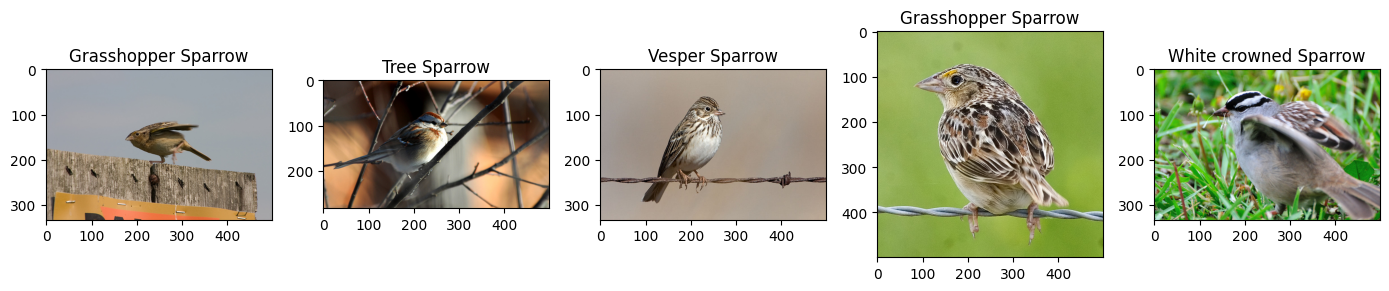

In [5]:
random.seed(RANDOM_SEED)
in_dir_data = 'data/CUB_200_2011/'
in_dir_img = os.path.join(in_dir_data, 'images')

# obtain classes of sparrow species
img_sparrows = dict()
cls_sparrows_total = [k for k in os.listdir(in_dir_img) if 'sparrow' in k.lower()]

# get images of some sparrow classes 
cls_sparrows = cls_sparrows_total[1::2][:5]
for dirname in cls_sparrows:
    imgs = list()
    for dp, _, fn in os.walk(os.path.join(in_dir_img, dirname)):
        imgs.extend(fn)
    img_sparrows[dirname] = imgs

# visualize randomly-chosen images
n_cls = len(cls_sparrows)
f, ax = plt.subplots(1, n_cls, figsize=(14, 8))

for i in range(n_cls):
    cls_name = cls_sparrows[random.randint(0, n_cls - 1)]
    n_img = len(img_sparrows[cls_name])
    img_name = img_sparrows[cls_name][random.randint(0, n_img - 1)]
    path_img = os.path.join(os.path.join(in_dir_img, cls_name), img_name)
    ax[i].imshow(mpimg.imread(path_img))
    ax[i].set_title(cls_name.split('.')[-1].replace('_', ' '),  fontsize=12)

    plt.tight_layout()
plt.show()

As we see, there can be a high similarity among birds related to different species which is really hard to spot. Is that a Song or a White-throated Sparrow? Well, even experts can be confused...

Just out of interest, we'll sum up all classes of the Sparrow family to understand how many of them in our dataset:

In [6]:
# print the total number of sparrow species
print(len(cls_sparrows_total))

21


There are several dozen different species, represented only by  sparrows. Too much honor ever for one family, isn't it? And now we see why the CUB-200-2011 dataset is perfectly designed for fine-grained classification. What do we have is the many similar birds potentially related to different classes.  

To understand how variable the image size is, let's analyze the widths and heights distribution of images:

Average sizes: 375.0 500.0


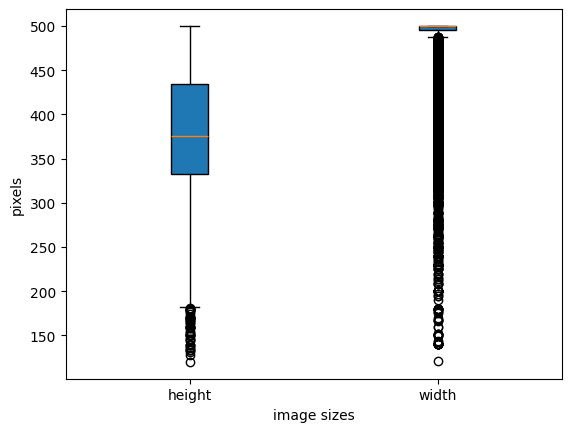

In [7]:
# calculate image statistics (takes some time to complete)
ds = tv.datasets.ImageFolder(in_dir_img)
shapes = [(img.height, img.width) for img, _ in ds]
heights, widths = [[h for h,_ in shapes], [w for _,w in shapes]]
print('Average sizes:', *map(np.median, zip(*shapes)))

# visualize the distribution of the size of images
fig = plt.figure()
ax = fig.add_subplot(111)

bp = ax.boxplot([heights, widths], patch_artist=True)

ax.set_xticklabels(['height', 'width'])
ax.set_xlabel('image sizes')
ax.set_ylabel('pixels')

plt.show()

Indeed, the size of images varies considerably, with the maximum size of 500 pixels along both dimension. We may also noticed that heights and widths are usually 375 and 500 pixels, respectively. You will see how to use obtained statistics in our the further analysis during the data preparation phase. 

### Question 3: Are there any image-specific biases that can limit the model performance?

In order to choose the appropriate way for the data augmentation later on, we want to estimate the position on which bird are rather to be located. For that, we'll standardize images to its global maximum size, and then visualize an average image, as follows:

  0%|          | 0/11788 [00:00<?, ?it/s]

100%|██████████| 11788/11788 [00:50<00:00, 234.00it/s]


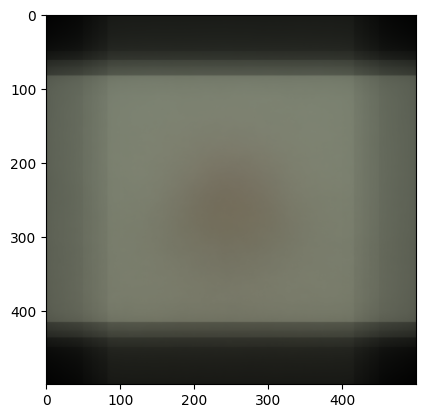

In [8]:
def pad(img, fill=0, size_max=500):
    """
    Pads images to the specified size (height x width). 
    Fills up the padded area with value(s) passed to the `fill` parameter. 
    """
    dimensions = tv.transforms.functional.get_image_size(img)
    pad_height = max(0, size_max - dimensions[1])
    pad_width = max(0, size_max - dimensions[0])
    
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    return TF.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=fill)


# instantiate dataset object
ds = tv.datasets.ImageFolder(in_dir_img, transform=tv.transforms.ToTensor())

# calculate an average image  
img_mean = np.zeros((3, 500, 500))
for img, _ in tqdm.tqdm(ds):
    img = pad(img)
    img_mean += img.numpy()

img_mean = img_mean / len(ds)

# visualize the average image  
plt.imshow(np.moveaxis(img_mean, 0, 2))
plt.show()

It seems like we have to deal with center-biased data, as the majority of birds are located around the middle of images. Thus, it can lead the model to primary focus on that image area, while missing relevant objects located in other parts of images. Next chapter explains how to overcome this problem using data augmentation.


## Data preparation<a class="anchor" id="prep"></a>

CUB-200-2011 dataset contains thousands of images, so it might affect the computational time. To overcome that we first create class `DatasetBirds` to make data loading and pre-processing easy: 

In [9]:
class DatasetBirds(tv.datasets.ImageFolder):
    """
    Wrapper for the CUB-200-2011 dataset. 
    Method DatasetBirds.__getitem__() returns tuple of image and its corresponding label.    
    """
    def __init__(self,
                 root,
                 transform=None,
                 target_transform=None,
                 loader=tv.datasets.folder.default_loader,
                 is_valid_file=None,
                 train=True,
                 bboxes=False):

        img_root = os.path.join(root, 'images')

        super(DatasetBirds, self).__init__(
            root=img_root,
            transform=None,
            target_transform=None,
            loader=loader,
            is_valid_file=is_valid_file,
        )

        self.transform_ = transform
        self.target_transform_ = target_transform
        self.train = train
        
        # obtain sample ids filtered by split
        path_to_splits = os.path.join(root, 'train_test_split.txt')
        indices_to_use = list()
        with open(path_to_splits, 'r') as in_file:
            for line in in_file:
                idx, use_train = line.strip('\n').split(' ', 2)
                if bool(int(use_train)) == self.train:
                    indices_to_use.append(int(idx))

        # obtain filenames of images
        path_to_index = os.path.join(root, 'images.txt')
        filenames_to_use = set()
        with open(path_to_index, 'r') as in_file:
            for line in in_file:
                idx, fn = line.strip('\n').split(' ', 2)
                if int(idx) in indices_to_use:
                    filenames_to_use.add(fn)

        img_paths_cut = {'/'.join(img_path.rsplit('/', 2)[-2:]): idx for idx, (img_path, lb) in enumerate(self.imgs)}
        imgs_to_use = [self.imgs[img_paths_cut[fn]] for fn in filenames_to_use]

        _, targets_to_use = list(zip(*imgs_to_use))

        self.imgs = self.samples = imgs_to_use
        self.targets = targets_to_use

        if bboxes:
            # get coordinates of a bounding box
            path_to_bboxes = os.path.join(root, 'bounding_boxes.txt')
            bounding_boxes = list()
            with open(path_to_bboxes, 'r') as in_file:
                for line in in_file:
                    idx, x, y, w, h = map(lambda x: float(x), line.strip('\n').split(' '))
                    if int(idx) in indices_to_use:
                        bounding_boxes.append((x, y, w, h))

            self.bboxes = bounding_boxes
        else:
            self.bboxes = None

    def __getitem__(self, index):
        # generate one sample
        sample, target = super(DatasetBirds, self).__getitem__(index)

        if self.bboxes is not None:
            # squeeze coordinates of the bounding box to range [0, 1]
            width, height = sample.width, sample.height
            x, y, w, h = self.bboxes[index]

            scale_resize = 500 / width
            scale_resize_crop = scale_resize * (375 / 500)

            x_rel = scale_resize_crop * x / 375
            y_rel = scale_resize_crop * y / 375
            w_rel = scale_resize_crop * w / 375
            h_rel = scale_resize_crop * h / 375

            target = torch.tensor([target, x_rel, y_rel, w_rel, h_rel])

        if self.transform_ is not None:
            sample = self.transform_(sample)
        if self.target_transform_ is not None:
            target = self.target_transform_(target)

        return sample, target

### Transforming and Splitting the data 

In order to improve the ability of the model to learn the representation of birds, we are going to use data augmentation. As you may have noticed in our previous analysis, the image size varies considerably, images have rather a landscape layout and the width is commonly close to the maximum value along both dimensions.

So before getting to a real deep learning, we'll apply our data-driven approach to transform images. To maintain the aspect ratio of images, we can transform them similarly, so that both dimensions are equal to 500 pixels. Here, it will be done using the maximum padding strategy:

In [10]:
# fill padded area with ImageNet's mean pixel value converted to range [0, 255]
fill = tuple(map(lambda x: int(round(x * 256)), (0.485, 0.456, 0.406)))
# pad images to 500 pixels
max_padding = tv.transforms.Lambda(lambda x: pad(x, fill=fill))

Previously, we have also found the majority of images to be center-biased. To overcome this problem, we make the model able to capture birds everywhere by randomly-cropping and flipping images along both axes during the model training. 

At the same time, test images will be center-cropped by 375 pixels before feeding into the model, given the majority birds are located at this middle area as we found before. Then, we are going to normalize all images by ImageNet's statistics, as follows:

In [11]:
# fill padded area with ImageNet's mean pixel value converted to range [0, 255]
fill = tuple(map(lambda x: int(round(x * 256)), (0.485, 0.456, 0.406)))

# transform images
transforms_train = tv.transforms.Compose([
   max_padding,
   tv.transforms.RandomOrder([
       tv.transforms.RandomCrop((375, 375)),
       tv.transforms.RandomHorizontalFlip(),
       tv.transforms.RandomVerticalFlip()
   ]),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transforms_eval = tv.transforms.Compose([
   max_padding,
   tv.transforms.CenterCrop((375, 375)),
   tv.transforms.ToTensor(),
   tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Then, we'll organize images of the CUB-200-2011 dataset into three subsets to insure the proper model training and evaluation:

In [12]:
# instantiate dataset objects according to the pre-defined splits
ds_train = DatasetBirds(in_dir_data, transform=transforms_train, train=True)
ds_val = DatasetBirds(in_dir_data, transform=transforms_eval, train=True)
ds_test = DatasetBirds(in_dir_data, transform=transforms_eval, train=False)

splits = skms.StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=RANDOM_SEED)
idx_train, idx_val = next(splits.split(np.zeros(len(ds_train)), ds_train.targets))

We will also set up parameters for the data loading and model training. To leverage computations and be able to proceed large dataset in parallel, we will collate input samples in several minibatches and also denote how many sub-processes to use to generate them.

In [13]:
# set hyper-parameters
params = {'batch_size': 24, 'num_workers': 8}
num_epochs = 100
num_classes = 200

After we'll create a `DataLoader` object to yield samples of an each data split into 24 batches and 8 workers, as follows:

In [14]:
# instantiate data loaders
train_loader = td.DataLoader(
   dataset=ds_train,
   sampler=td.SubsetRandomSampler(idx_train),
   **params
)
val_loader = td.DataLoader(
   dataset=ds_val,
   sampler=td.SubsetRandomSampler(idx_val),
   **params
)
test_loader = td.DataLoader(dataset=ds_test, **params)

## Modelling<a class="anchor" id="model-base"></a>
### Building a baseline ResNet-50 classifier

In this tutorial, we are going to use ResNet-50 model for classification of bird species. ResNet (stands for Residual Networks) is a variant of convolutional neural networks that was [proposed](https://arxiv.org/abs/1512.03385, 'He et. al, 2015') as a solution to the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) of large networks by using the skip or residual connections. 
PyTorch provides the ResNet-50 among the other ready-to-use deep learning models on `torchvision.models`, so we'll instantiate the respective class. Given the dataset of 200 bird species, we will set the argument *num_classes* to that number, and also define the device on which to run the model.

In [15]:
# instantiate the model
model = tv.models.resnet50(num_classes=num_classes).to(DEVICE)

More specifically, the chosen architecture is 50 layers deep and composed of 5 stages, 4 of which with residual blocks and 1 comprise a convolution, batch normalization and ReLU operations, namely:

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training and evaluation of the model <a class="anchor" id="train-test"></a>

Next point is to define the learning rate of our model as well as a schedule to adjust it during training for the sake of the better performance. Training of the ResNet-50 model will be done using the Adam optimizer with an initial learning rate of 1e-3 and an exponentially decreasing learning rate schedule such as it drops by a factor of *gamma* at each epoch.

In [ ]:
# instantiate optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

Now, we are ready to train and validate our model to recognize and learn the difference between bird species. We'll also display cross-entropy loss values for an each 10 epoch in order to evaluate the model performance dynamics following the training and validation block:

In [1]:
# generate model description string
model_desc = get_model_desc(num_classes=num_classes)

# define the training loop
best_snapshot_path = None
val_acc_avg = list()
best_val_acc = -1.0

for epoch in range(num_epochs):
    
    # train the model
    model.train()
    train_loss = list()
    for batch in train_loader:
        x, y = batch
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        optimizer.zero_grad()
        
        # predict bird species
        y_pred = model(x)
        
        # calculate the loss
        loss = F.cross_entropy(y_pred, y)
        
        # backprop & update weights 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
    # validate the model
    model.eval()
    val_loss = list()
    val_acc = list()
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch

            x = x.to(DEVICE)
            y = y.to(DEVICE)

            # predict bird species
            y_pred = model(x)

            # calculate the loss
            loss = F.cross_entropy(y_pred, y)
            
            # calculate the accuracy
            acc = skms.accuracy_score([val.item() for val in y], [val.item() for val in y_pred.argmax(dim=-1)])

            val_loss.append(loss.item())
            val_acc.append(acc)

        val_acc_avg.append(np.mean(val_acc))
            
        # save the best model snapshot
        current_val_acc = val_acc_avg[-1]
        if current_val_acc > best_val_acc:
            if best_snapshot_path is not None:
                os.remove(best_snapshot_path)

            best_val_acc = current_val_acc
            best_snapshot_path = os.path.join(OUT_DIR, f'model_{model_desc}_ep={epoch}_acc={best_val_acc}.pt')

            torch.save(model.state_dict(), best_snapshot_path)
    
    # adjust the learning rate
    scheduler.step()

    # print performance metrics
    if (epoch == 0) or ((epoch + 1) % 10 == 0):
        print('Epoch {} |> Train. loss: {:.4f} | Val. loss: {:.4f}'.format(
            epoch + 1, np.mean(train_loss), np.mean(val_loss))
        )

NameError: name 'get_model_desc' is not defined

After all of the training experiments have concluded, we perform the model evaluation on the subset of previously unseen data to assess the overall goodness of the model. The latter will be evaluated using the accuracy metric.

In [25]:
# load snapshot of the best model
model.load_state_dict(torch.load(best_snapshot_path, map_location=DEVICE))
        
# test the model
true = list()
pred = list()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # predict bird species
        y_pred = model(x)

        true.extend([val.item() for val in y])
        pred.extend([val.item() for val in y_pred.argmax(dim=-1)])

# calculate the accuracy 
test_accuracy = skms.accuracy_score(true, pred)
print('Test accuracy: {:.3f}'.format(test_accuracy))

Test accuracy: 0.360


What do we see? The baseline model performs really poor as it overfits. The one of main reasons is the lack of diverse training samples. Just a quick note: CUB-200-2011 dataset has ~30 images per specie. Seems like we are stuck...isn't it? Actually, there are some options to overcome this issue, which will be elaborated next in more detail. 

## Advancing the deep learning model <a class="anchor" id="model-adv"></a>

Well, we ran into a number of challenges during our analysis, so we could start thinking about these follow-up questions:

* Question 4: How to handle overfitting given the limited amount of training samples? ([Solution 1](#adv-trns))
* Question 5: How to improve the model performance in bird classification task? ([Solutions 2 & 3](#adv-mtl-attn))

There are several techniques that can be applied to address the aforementioned questions, such as transfer learning, auxiliary task, the use of the attention-enhanced CNN. Let’s figure out how we can apply them in order to improve the network's ability to predict bird species.

### Question 4: How to handle overfitting given the limited amount of training samples? <a class="anchor" id="adv-trns"></a>

As it was said before, deep neural networks require a lot of training samples. Practitioners have noticed that, in order to train a deep neural network from scratch, the amount of data should grow exponentially with the number of trainable parameters. The minimal number of samples per class should be roughly 1k or more (which is, of course, preferable), however it's rarely the case when we possess large enough datasets.

Luckily, generalization ability of a model that was trained on a larger dataset can be transferred to another, usually, simpler task. In order to reduce the overfitting of our baseline model, we will use weight initialization obtained from the general-purpose model pre-trained on the ImageNet dataset, and further optimize its hyper-parameters using the CUB-200-2011 dataset.

Construction of a pre-trained ResNet-50 in PyTorch can be done by passing pretrained=True into constructor. This simple trick provides us with the model that already has well initialized filters, so there is no need to learn them from scratch. We will also set the learning rate 10 times lower, as we are going to train a network that was yet pre-trained on a large-scale image-classification task. Thus, the training process remains the same, while the model will rather focus on the fine-tuning of parameters.

In [26]:
# define hyper-parameters
pretrained = True
num_classes = 200

model_desc = get_model_desc(num_classes=num_classes, pretrained=pretrained)

# instantiate the model
model = tv.models.resnet50(num_classes=num_classes, pretrained=pretrained).to(DEVICE)

# instantiate optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# train and validate the model
best_snapshot_path = None
val_acc_avg = list()
best_val_acc = -1.0

for epoch in range(num_epochs):
    
    # train the model
    model.train()
    train_loss = list()
    for batch in train_loader:
        x, y = batch
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        optimizer.zero_grad()
        
        # calculate the loss
        y_pred = model(x)
        
        # calculate the loss
        loss = F.cross_entropy(y_pred, y)
        
        # backprop & update weights 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
    # validate the model
    model.eval()
    val_loss = list()
    val_acc = list()
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch

            x = x.to(DEVICE)
            y = y.to(DEVICE)
            
            # predict bird species
            y_pred = model(x)

            # calculate the loss
            loss = F.cross_entropy(y_pred, y)
            
            # calculate the accuracy
            acc = skms.accuracy_score([val.item() for val in y], [val.item() for val in y_pred.argmax(dim=-1)])

            val_loss.append(loss.item())
            val_acc.append(acc)

        val_acc_avg.append(np.mean(val_acc))
            
        # save the best model snapshot
        current_val_acc = val_acc_avg[-1]
        if current_val_acc > best_val_acc:
            if best_snapshot_path is not None:
                os.remove(best_snapshot_path)

            best_val_acc = current_val_acc
            best_snapshot_path = os.path.join(OUT_DIR, f'model_{model_desc}_ep={epoch}_acc={best_val_acc}.pt')

            torch.save(model.state_dict(), best_snapshot_path)

    # adjust the learning rate
    scheduler.step()

    # print performance metrics
    if (epoch == 0) or ((epoch + 1) % 10 == 0):
        print('Epoch {} |> Train. loss: {:.4f} | Val. loss: {:.4f}'.format(
            epoch + 1, np.mean(train_loss), np.mean(val_loss))
        )
        
# use the best model snapshot
model.load_state_dict(torch.load(best_snapshot_path, map_location=DEVICE))
        
# test the model
true = list()
pred = list()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y_pred = model(x)

        true.extend([val.item() for val in y])
        pred.extend([val.item() for val in y_pred.argmax(dim=-1)])

# calculate the accuracy 
test_accuracy = skms.accuracy_score(true, pred)

# save the accuracy
path_to_logs = f'{OUT_DIR}/logs.csv'
log_accuracy(path_to_logs, model_desc, test_accuracy)

print('Test accuracy: {:.3f}'.format(test_accuracy))

Epoch 1 |> Train. loss: 4.4436 | Val. loss: 3.1796
Epoch 10 |> Train. loss: 0.3002 | Val. loss: 0.8672
Epoch 20 |> Train. loss: 0.0413 | Val. loss: 0.7459
Epoch 30 |> Train. loss: 0.0130 | Val. loss: 0.7373
Epoch 40 |> Train. loss: 0.0060 | Val. loss: 0.7150
Epoch 50 |> Train. loss: 0.0030 | Val. loss: 0.7229
Epoch 60 |> Train. loss: 0.0019 | Val. loss: 0.7336
Epoch 70 |> Train. loss: 0.0014 | Val. loss: 0.7394
Epoch 80 |> Train. loss: 0.0011 | Val. loss: 0.7391
Epoch 90 |> Train. loss: 0.0010 | Val. loss: 0.7586
Epoch 100 |> Train. loss: 0.0008 | Val. loss: 0.7395
Test accuracy: 0.808


As we see, the use of the pre-trained model allows to reduce the model overfitting giving the test accuracy of 80.8%.

### Question 5: How to improve the model performance in bird classification task? <a class="anchor" id="adv-mtl-attn"></a>

#### Boosting the model perfromance using multi-task learning

Previously, we considered one option to make the model's task harder - the data augmentation. Now we can extend this approach even more. It was noticed that introduction of an additional - auxiliary - task improves the network's performance forcing it to learn more general representation of the training data. 

The Caltech-UCSD Birds-200-2011 dataset includes not only class labels but also bounding boxes. We will use this auxiliary target to make the network to train in a multi-task fashion. Now, we will predict 4 coordinates of bird's bounding box as well as its specie. Here's an example execution:

In [27]:
# define hyper-parameters
pretrained = True
num_classes = 200 + 4

model_desc = get_model_desc(num_classes=num_classes, pretrained=pretrained)

# instantiate the pre-trained model
model = tv.models.resnet50(num_classes=num_classes, pretrained=pretrained).to(DEVICE)

# instantiate optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# train and validate the model
best_snapshot_path = None
val_acc_avg = list()
best_val_acc = -1.0

for epoch in range(num_epochs):
    
    # train the model
    model.train()
    train_loss = list()
    for batch in train_loader:
        x, y = batch
        
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        optimizer.zero_grad()
        
        y_pred = model(x)
        
        # predict bird species
        y_pred_cls = y_pred[..., :-4]
        y_cls = y[..., 0].long()
        # predict bounding box coordinates
        y_pred_bbox = y_pred[..., -4:]
        y_bbox = y[..., 1:]

        # calculate the loss
        loss_cls = F.cross_entropy(y_pred_cls, y_cls)
        loss_bbox = F.mse_loss(torch.sigmoid(y_pred_bbox), y_bbox)
        loss = loss_cls + loss_bbox
        
        # backprop & update weights 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
    # validate the model
    model.eval()
    val_loss = list()
    val_acc = list()
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch

            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y_pred = model(x)

            # predict bird species
            y_pred_cls = y_pred[..., :-4]
            y_cls = y[..., 0].long()
            # predict bounding box coordinates
            y_pred_bbox = y_pred[..., -4:]
            y_bbox = y[..., 1:]
            
            # calculate the loss
            loss_cls = F.cross_entropy(y_pred_cls, y_cls)
            loss_bbox = F.mse_loss(torch.sigmoid(y_pred_bbox), y_bbox)
            loss = loss_cls + loss_bbox
            
            # calculate the accuracy
            acc = skms.accuracy_score([val.item() for val in y], [val.item() for val in y_pred.argmax(dim=-1)])

            val_loss.append(loss.item())
            val_acc.append(acc)

        val_acc_avg.append(np.mean(val_acc))
            
        # save the best model snapshot
        current_val_acc = val_acc_avg[-1]
        if current_val_acc > best_val_acc:
            if best_snapshot_path is not None:
                os.remove(best_snapshot_path)

            best_val_acc = current_val_acc
            best_snapshot_path = os.path.join(OUT_DIR, f'model_{model_desc}_ep={epoch}_acc={best_val_acc}.pt')

            torch.save(model.state_dict(), best_snapshot_path)
    
    # adjust the learning rate
    scheduler.step()

    # print performance metrics
    if (epoch == 0) or ((epoch + 1) % 10 == 0):
        print('Epoch {} |> Train. loss: {:.4f} | Val. loss: {:.4f}'.format(
            epoch + 1, np.mean(train_loss), np.mean(val_loss))
        )
        
# use the best model snapshot
model.load_state_dict(torch.load(best_snapshot_path, map_location=DEVICE))
        
# test the model
true = list()
pred = list()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y_pred = model(x)
        
        y = y[..., 0]
        y_pred = y_pred[..., :-4]

        true.extend([val.item() for val in y])
        pred.extend([val.item() for val in y_pred.argmax(dim=-1)])

# calculate and save the accuracy
test_accuracy = skms.accuracy_score(true, pred)
log_accuracy(path_to_logs, model_desc, test_accuracy)

print('Test accuracy: {:.3f}'.format(test_accuracy))

Epoch 1 |> Train. loss: 4.4768 | Val. loss: 3.2311
Epoch 10 |> Train. loss: 0.3010 | Val. loss: 0.9248
Epoch 20 |> Train. loss: 0.0413 | Val. loss: 0.8760
Epoch 30 |> Train. loss: 0.0131 | Val. loss: 0.8401
Epoch 40 |> Train. loss: 0.0075 | Val. loss: 0.8440
Epoch 50 |> Train. loss: 0.0045 | Val. loss: 0.8702
Epoch 60 |> Train. loss: 0.0029 | Val. loss: 0.8710
Epoch 70 |> Train. loss: 0.0022 | Val. loss: 0.8674
Epoch 80 |> Train. loss: 0.0017 | Val. loss: 0.8891
Epoch 90 |> Train. loss: 0.0015 | Val. loss: 0.8781
Epoch 100 |> Train. loss: 0.0014 | Val. loss: 0.8797
Test accuracy: 0.810


Results are even better - integration of auxiliary task provides the stable increase of accuracy points giving 81% on the test split. Can we improve it further?

#### Enhancing the network using attention mechanism

In the last few paragraphs we were focused on the data-driven improvement of our model. However, at some point the complexity of the task can exceed the model's capacity resulting in a lower performance. In order to adjust the model's power to the difficulty of the problem, we can equip the network with additional *attention blocks* that will help it to focus on important parts of the input and ignore irrelevant ones:

In [31]:
class Attention(torch.nn.Module):
    """
    Attention block for CNN model.
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(Attention, self).__init__()

        self.conv_depth = torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, groups=in_channels)
        self.conv_point = torch.nn.Conv2d(out_channels, out_channels, kernel_size=(1, 1))
        self.bn = torch.nn.BatchNorm2d(out_channels, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True)
        self.activation = torch.nn.Tanh()

    def forward(self, inputs):
        x, output_size = inputs
        x = F.adaptive_max_pool2d(x, output_size=output_size)
        x = self.conv_depth(x)
        x = self.conv_point(x)
        x = self.bn(x)
        x = self.activation(x) + 1.0

        return x

Attention module allows to highlight relevant regions of feature maps and returns values varying in range [0.0, 2.0], where the lower value implies the lower priority of a given pixel for the following layers. So we'll use it in class `ResNet50Attention` corresponding to the attention-enhanced ResNet-50 model:

In [32]:
class ResNet50Attention(torch.nn.Module):
    """
    Attention-enhanced ResNet-50 model.
    """

    weights_loader = staticmethod(tv.models.resnet50)

    def __init__(self, num_classes=200, pretrained=True, use_attention=True):
        super(ResNet50Attention, self).__init__()

        net = self.weights_loader(pretrained=pretrained)
        self.num_classes = num_classes
        self.pretrained = pretrained
        self.use_attention = use_attention

        net.fc = torch.nn.Linear(
            in_features=net.fc.in_features,
            out_features=num_classes,
            bias=net.fc.bias is not None
        )

        self.net = net

        if self.use_attention:
            self.att1 = Attention(in_channels=64, out_channels=64, kernel_size=(3, 5), padding=(1, 2))
            self.att2 = Attention(in_channels=64, out_channels=128, kernel_size=(5, 3), padding=(2, 1))
            self.att3 = Attention(in_channels=128, out_channels=256, kernel_size=(3, 5), padding=(1, 2))
            self.att4 = Attention(in_channels=256, out_channels=512, kernel_size=(5, 3), padding=(2, 1))

            if pretrained:
                self.att1.bn.weight.data.zero_()
                self.att1.bn.bias.data.zero_()
                self.att2.bn.weight.data.zero_()
                self.att2.bn.bias.data.zero_()
                self.att3.bn.weight.data.zero_()
                self.att3.bn.bias.data.zero_()
                self.att4.bn.weight.data.zero_()
                self.att4.bn.bias.data.zero_()

    def _forward(self, x):
        return self.net(x)
    
    def _forward_att(self, x):
        x = self.net.conv1(x)
        x = self.net.bn1(x)
        x = self.net.relu(x)
        x = self.net.maxpool(x)

        x_a = x.clone()
        x = self.net.layer1(x)
        x = x * self.att1((x_a, x.shape[-2:]))

        x_a = x.clone()
        x = self.net.layer2(x)
        x = x * self.att2((x_a, x.shape[-2:]))

        x_a = x.clone()
        x = self.net.layer3(x)
        x = x * self.att3((x_a, x.shape[-2:]))

        x_a = x.clone()
        x = self.net.layer4(x)
        x = x * self.att4((x_a, x.shape[-2:]))

        x = self.net.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.net.fc(x)

        return x
    
    def forward(self, x):
        return self._forward_att(x) if self.use_attention else self._forward(x)

Now, we are ready to train and evaluate the performance of our attention-enhanced model:

In [33]:
# define hyper-parameters
pretrained = True
num_classes = 200 + 4
use_attention = True

model_desc = get_model_desc(num_classes=num_classes, pretrained=pretrained, use_attention=use_attention)

# instantiate the model
model = ResNet50Attention(num_classes=num_classes, pretrained=pretrained, use_attention=use_attention).to(DEVICE)

# instantiate optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# train and validate the model
best_snapshot_path = None
val_acc_avg = list()
best_val_acc = -1.0

for epoch in range(num_epochs):
    
    # train the model
    model.train()
    train_loss = list()
    for batch in train_loader:
        x, y = batch

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()

        y_pred = model(x)

        # predict bird species
        y_pred_cls = y_pred[..., :-4]
        y_cls = y[..., 0].long()
        # predict bounding box coordinates
        y_pred_bbox = y_pred[..., -4:]
        y_bbox = y[..., 1:]

        # calculate the loss
        loss_cls = F.cross_entropy(y_pred_cls, y_cls)
        loss_bbox = F.mse_loss(torch.sigmoid(y_pred_bbox), y_bbox)
        loss = loss_cls + loss_bbox
        
        # backprop & update weights 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
    # validate the model
    model.eval()
    val_loss = list()
    val_acc = list()
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch

            x = x.to(DEVICE)
            y = y.to(DEVICE)

            y_pred = model(x)
            
            # predict bird species
            y_pred_cls = y_pred[..., :-4]
            y_cls = y[..., 0].long()
            # predict bounding box coordinates
            y_pred_bbox = y_pred[..., -4:]
            y_bbox = y[..., 1:]

            # calculate the loss
            loss_cls = F.cross_entropy(y_pred_cls, y_cls)
            loss_bbox = F.mse_loss(torch.sigmoid(y_pred_bbox), y_bbox)
            loss = loss_cls + loss_bbox

            # calculate the accuracy
            acc = skms.accuracy_score([val.item() for val in y], [val.item() for val in y_pred.argmax(dim=-1)])

            val_loss.append(loss.item())
            val_acc.append(acc)

        val_acc_avg.append(np.mean(val_acc))
            
        # save the best model snapshot
        current_val_acc = val_acc_avg[-1]
        if current_val_acc > best_val_acc:
            if best_snapshot_path is not None:
                os.remove(best_snapshot_path)

            best_val_acc = current_val_acc
            best_snapshot_path = os.path.join(OUT_DIR, f'model_{model_desc}_ep={epoch}_acc={best_val_acc}.pt')

            torch.save(model.state_dict(), best_snapshot_path)
    
    # adjust the learning rate
    scheduler.step()

    # print performance metrics
    if (epoch == 0) or ((epoch + 1) % 10 == 0):
        print('Epoch {} |> Train. loss: {:.4f} | Val. loss: {:.4f}'.format(
            epoch + 1, np.mean(train_loss), np.mean(val_loss))
        )
        
# use the best model snapshot
model.load_state_dict(torch.load(best_snapshot_path, map_location=DEVICE))
        
# test the model
true = list()
pred = list()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch

        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y_pred = model(x)
        
        y = y[..., 0]
        y_pred = y_pred[..., :-4]

        true.extend([val.item() for val in y])
        pred.extend([val.item() for val in y_pred.argmax(dim=-1)])

# calculate and save the accuracy
test_accuracy = skms.accuracy_score(true, pred)
log_accuracy(path_to_logs, model_desc, test_accuracy)

print('Test accuracy: {:.3f}'.format(test_accuracy))


Epoch 1 |> Train. loss: 4.1665 | Val. loss: 2.5647
Epoch 10 |> Train. loss: 0.1174 | Val. loss: 0.7010
Epoch 20 |> Train. loss: 0.0370 | Val. loss: 0.8043
Epoch 30 |> Train. loss: 0.0253 | Val. loss: 0.7479
Epoch 40 |> Train. loss: 0.0249 | Val. loss: 0.7495
Epoch 50 |> Train. loss: 0.0166 | Val. loss: 0.7848
Epoch 60 |> Train. loss: 0.0167 | Val. loss: 0.8106
Epoch 70 |> Train. loss: 0.0159 | Val. loss: 0.8149
Epoch 80 |> Train. loss: 0.0116 | Val. loss: 0.8171
Epoch 90 |> Train. loss: 0.0128 | Val. loss: 0.7887
Test accuracy: 0.8243


Results clearly indicate that the final variant of the ResNet-50 model advanced with transfer and multi-task learning, as well as with the attention module greatly contributes to the more accurate bird predictions providing additional accuracy points reaching 82.4%


## Evaluation of the results<a class="anchor" id="eval"></a>
Finally, let's visualize the summary results of our analysis:

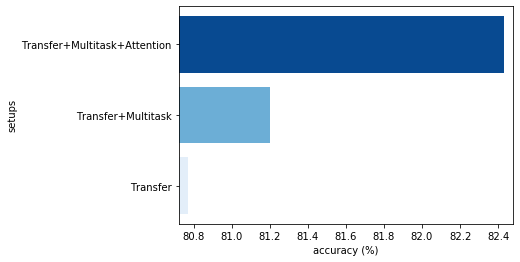

In [34]:
def tab_separator(row):
    """
    Splits the row by tab.
    """
    return row[0].split('\t')


# load accuracy results
logs = {}
with open('results/logs.csv', 'r') as f:
    reader = csv.reader(f)
    headers = tab_separator(next(reader))
    
    for h in headers:
        logs[h] = []
    for row in reader:
        for h, v in zip(headers, tab_separator(row)):
            if h == 'accuracy':
                v = round(float(v) * 100, 1)
            logs[h].append(v)
            
# visualize the summary model performance
cmap = mpl.cm.get_cmap('Blues_r')
colors = [cmap(0.9), cmap(0.5), cmap(0.1)]
x_min, x_max = np.min(logs['accuracy']), np.max(logs['accuracy'])

plt.barh(logs['setup'], logs['accuracy'], color=colors)
plt.xlim(x_min - 5e-2, x_max + 5e-2)
plt.xlabel('accuracy (%)')
plt.ylabel('setups')
plt.show()

## Conclusions

Here, we used different approaches to improve the performance of a baseline ResNet-50 for the classification of bird species from CUB-200-2011 dataset. What could we learn from that? Here are some take-home messages from our analysis:

* Data exploration results indicate the CUB-200-2011 as the high-quality, balanced although center-biased dataset without corrupted images. 

* In case of the limited amount of training samples, you can reuse weights of the model pre-trained on another (usually larger) dataset in your own model. 

* Learning through auxiliary task in addition to the primary bird classification one contributes to the better model performance.

* Enhancing the network's architecture by adding new layers (attention  module) makes the model more accurate in bird species classification.

* Comparison resuls of different extentions of the basic ResNet-50 indicate the pre-trained model advanced using auxialary task and attention mechanism as the prominent candidate for the further investigations. 

In summary, there is a space for improvements of the model performance. Additional advancements can be achieved by further optimization of model hyper-parameters, the use of a stronger data augmentation, regularization, meta-learning techniques, and many more.

## More coming soon! 


The focus of the **next tutorial** will be on the **interpretability of deep learning models**. Interested to keep it on? 

Subscribe and stay updated on more deep learning materials at  —  https://medium.com/@slipnitskaya and https://github.com/slipnitskaya .

___

Except as otherwise noted, the content of the above materials is licensed under the Creative Commons Attribution Non Commercial 4.0 International, and code samples are licensed under the Apache 2.0 License.